# Hypothesis 5

Prepare the final ML Pipeline.

1. Rename this notebook from `H5.ipynb` to `5_{Name}_{Surname}.ipynb`
2. You should use **ORIGINAL** dataset (**NOT from `H1`**): `train.csv` and `0_{Name}_{Surname}_test.csv` files
3. Prepare two separate final Scikit Learn Pipelines (see lecture 8) for **Churn** and for **Price_doc** targets
    - The pipeline for **EACH** model should have its own **unique hyper-parameters**
    - All key parameters must be specified in the pipeline (e.g. SimpleImputer() without parameters will not be suitable).
    - For each pipeline, it should be written how many features are used in the final model
4. Calculate quality metrics and number of features for each pipeline
5. Send this notebook and preprocessed submission file in a private message in telegram.

## Notes:

### 1. All code in notebook must be run

### 2. Do not modify the code after "YOUR WORK IS DONE (Do not modify the code after)" and the code after should executed

### 3. Your solution must meet the minimum quality metrics

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline

pd.set_option('mode.chained_assignment', None)
pd.options.display.max_rows = 100

In [4]:
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_absolute_percentage_error


def calc_all_metrics(data, max_account=25e3):

    def is_credit_issued(x):
        ratio = x['__price_predict'] / x['__price_doc']
        if x['__priority'] <= 0:
            value = 0.
        elif ratio > 0.9 and ratio < 1.:
            value = x['__price_predict']
        elif ratio >= 1. and ratio < 1.1:
            value = x['__price_doc']
        else:
            value = 0.

        return value

    def calc_profit(x):
        if x['is_credit'] == 0.:
            return 0.
        elif x['__churn'] == 1:
            return - x['debt'] * 2.
        elif x['debt'] < 5:
            return x['debt'] * 0.3
        elif x['debt'] < 9:
            return x['debt'] * 0.4
        elif x['debt'] >= 9:
            return x['debt'] * 0.5

    s = (
        data
        [['__priority', '__churn', '__churn_prob', '__price_doc', '__price_predict']]
        .sort_values('__priority', ascending=False)
        .copy(True)
    )

    s['debt'] = s.apply(is_credit_issued, axis=1)
    s['debt_cum'] = s['debt'].cumsum()
    s['is_credit'] = 0
    s.loc[(s['debt'] > 0) & (s['debt_cum'] <= max_account), 'is_credit'] = 1
    s['profit'] = s.apply(calc_profit, axis=1)

    total_profit = round(s['profit'].sum(), 2)
    good_credits_count = s['is_credit'].sum()
    good_credits_debt = round(s[s['is_credit'] == 1]['debt'].sum(), 2)
    bad_credits_count = s[s['is_credit'] == 1]['__churn'].sum()
    bad_credits_losses = s[(s['is_credit'] == 1) & (s['__churn'] == 1)]['debt'].sum()

    return {
        'total_profit': total_profit,
        '%profit_issued': round(total_profit / good_credits_debt * 100, 1),
        '%issued_loans': round(good_credits_debt / max_account * 100, 2),
        'issued_loans': good_credits_debt,
        'count_good': good_credits_count,
        'count_bad': bad_credits_count,
        '%bad': round(bad_credits_count / (good_credits_count + bad_credits_count) * 100., 1),
        'churn_auc': round(roc_auc_score(y_true=s['__churn'], y_score=s['__churn_prob']), 3),
        'price_nmsle': round(-mean_squared_log_error(y_true=s['__price_doc'], y_pred=s['__price_predict']), 3),
        'price_mape': round(-mean_absolute_percentage_error(y_true=s['__price_doc'], y_pred=s['__price_predict']), 3),
    }


# Use this line for pandas output!!!

In [5]:
from sklearn import set_config
set_config(transform_output = "pandas")

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_absolute_percentage_error


def metric_for_price(y_true, y_pred):
    """ mean_squared_log_error. bigger is better """
    return round(-mean_squared_log_error(y_true=y_true, y_pred=y_pred), 3)


def metric_for_churn(y_true, y_score):
    """ roc_auc_score. bigger is better """
    return round(roc_auc_score(y_true=y_true, y_score=y_score), 3)


In [7]:
#mount my google drive file
from google.colab import drive
drive.mount ('/content/drive')

Mounted at /content/drive


In [8]:
import numpy as np
import pandas as pd
pd.options.display.max_rows = 1000

# Your Name Surname
# !!! should not change in other hypotheses
NAME = "Belton_Manhica"

train_all = pd.read_csv(f"/content/drive/MyDrive/Machine Learning data/train.csv")
test = pd.read_csv(f"/content/drive/MyDrive/Machine Learning data/0_{NAME}_test.csv")

TRAIN_SHAPE, TEST_SHAPE = train_all.shape, test.shape
TRAIN_SHAPE, TEST_SHAPE

((20483, 61), (9183, 60))

In [9]:
# define a list of features
INPUT_FEATURES_CHURN = ['contacts_count_12_mon',
 'months_inactive_12_mon',
 'total_ct_chng_q4_q1',
 'total_relationship_count',
 'total_trans_ct',
 'total_trans_amt',
 'total_revolving_bal',
 'avg_open_to_buy',
 'avg_utilization_ratio',
 'marital_status',
 'gender',
 'credit_limit',
 'income_category',
 'dependent_count',
 'total_amt_chng_q4_q1',
 'customer_age']

INPUT_FEATURES_PRICE = ['full_sq',
'mkad_km',
'public_transport_station_min_walk',
'leisure_count_3000',
'total_ct_chng_q4_q1',
'cafe_sum_1000_min_price_avg',
'max_floor',
'build_year',
'culture_objects_top_25',
'state',
'life_sq',
'office_sqm_5000',
'leisure_count_5000' ,
'sport_count_2000'  ,
'railroad_station_walk_km' ,
'detention_facility_km' ,
'trc_count_2000' ,
'cafe_count_1000_price_1000' ,
'metro_km_walk' ,
'0_17_all' ,
'cafe_sum_1500_min_price_avg']

len(INPUT_FEATURES_CHURN), len(INPUT_FEATURES_PRICE)

(16, 21)

In [10]:
from sklearn.model_selection import train_test_split


train, valid, y_train_price, y_valid_price, y_train_churn, y_valid_churn = train_test_split(
    train_all, train_all['__price_doc'], train_all['__churn'],
    test_size=0.5, random_state=42,
)

print(train.shape, valid.shape,
      y_train_price.shape, y_valid_price.shape,
      y_train_churn.shape, y_valid_churn.shape)

(10241, 61) (10242, 61) (10241,) (10242,) (10241,) (10242,)


In [22]:
#import important libraries
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from typing import List


### Pipeline CHURN

In [13]:
#select categorical and numerical data
categorical_cols = train[INPUT_FEATURES_CHURN].select_dtypes(include=['object', 'bool']).columns.tolist()
numerical_cols = train[INPUT_FEATURES_CHURN].select_dtypes(include=['int64', 'float64']).columns.tolist()

In [20]:
def transformer(categorical_cols: List[str], numerical_cols: List[float]) -> ColumnTransformer:

  #create a pipeline for categorical data
    categorical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy= 'most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output = False)),
    ])

#create a pipeline for numerical data
    numerical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', QuantileTransformer(output_distribution='normal')),

    ])

    #create a numerical pipeline
    col_transformer= ColumnTransformer(transformers =[
    ('categorical', categorical_pipeline, categorical_cols),
    ('numerical', numerical_pipeline, numerical_cols)
    ])

    return col_transformer


In [23]:
transformed = transformer(categorical_cols, numerical_cols)
#apply transformations to the data
transformed.fit(train[INPUT_FEATURES_CHURN])

ColumnTransformer(transformers=[('categorical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['marital_status', 'gender',
                                  'income_category']),
                                ('numerical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler',
                                                  QuantileTransformer(output_distribution='normal'))]),
                                 ['contacts_count_12_mon',
                                  'months_inactive_12_mon',
                                  'total_ct_chng_q4_q1',
                                  'total_relationship_count', 'total_trans_ct',
                                  'total_trans_amt', 'total_revolving_bal',
                                  'avg_open_to_buy', 'avg_utilization_ratio',
                                  'credit_limit', 'dependent_count',
                                  'total_amt_chng_q4_q1', 'customer_age'])])

In [28]:
# train the model function
from xgboost import XGBClassifier
def train_model(transformed_data, feature_col, target):
  model = XGBClassifier(random_state= 47, max_depth=3, learning_rate = 0.1 )
  pipe_clf = make_pipeline(transformed_data, model)
  pipe_clf.fit(feature_col, target)

  return pipe_clf

In [32]:
pipe_clf= train_model(transformed, train[INPUT_FEATURES_CHURN], y_train_churn)
pipe_clf

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['marital_status', 'gender',
                                                   'income_category']),
                                                 ('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('sca...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

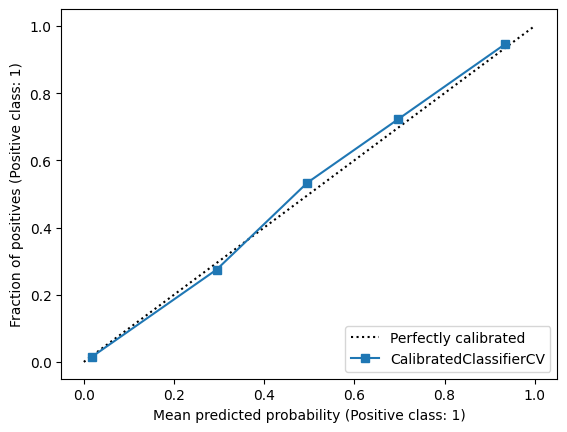

In [33]:
#calibrate the predictions
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import CalibrationDisplay
import matplotlib.pyplot as plt


model_clf = CalibratedClassifierCV(
    estimator = pipe_clf,
    cv = 2, method ='isotonic')

model_clf.fit(train[INPUT_FEATURES_CHURN], y_train_churn)

#plot the curve
disp = CalibrationDisplay.from_estimator(
    model_clf,
    valid[INPUT_FEATURES_CHURN],
    y_valid_churn)

plt.show()

In [34]:
y_pred_churn_train = pipe_clf.predict_proba(train[INPUT_FEATURES_CHURN])[:, 1]
y_pred_churn_valid = pipe_clf.predict_proba(valid[INPUT_FEATURES_CHURN])[:, 1]
metric_for_churn(y_train_churn, y_pred_churn_train), metric_for_churn(y_valid_churn, y_pred_churn_valid)

(np.float64(0.979), np.float64(0.974))

In [35]:
#cleck the scores for the calibrated model
y_pred_churn_train = model_clf.predict_proba(train[INPUT_FEATURES_CHURN])[:, 1]
y_pred_churn_valid = model_clf.predict_proba(valid[INPUT_FEATURES_CHURN])[:, 1]
metric_for_churn(y_train_churn, y_pred_churn_train), metric_for_churn(y_valid_churn, y_pred_churn_valid)

(np.float64(0.979), np.float64(0.974))

In [36]:
train_all['__churn_prob'] = pipe_clf.predict_proba(train_all[INPUT_FEATURES_CHURN])[:, 1]
train['__churn_prob'] = pipe_clf.predict_proba(train[INPUT_FEATURES_CHURN])[:, 1]
valid['__churn_prob'] = pipe_clf.predict_proba(valid[INPUT_FEATURES_CHURN])[:, 1]
test['__churn_prob'] = pipe_clf.predict_proba(test[INPUT_FEATURES_CHURN])[:, 1]

### Pipeline PRICE_DOC

In [38]:
#select categorical and numerical data
categorical_cols_price = train[INPUT_FEATURES_PRICE].select_dtypes(include=['object', 'bool']).columns.tolist()
numerical_cols_price = train[INPUT_FEATURES_PRICE].select_dtypes(include=['int64', 'float64']).columns.tolist()

In [41]:
transformed_price = transformer(categorical_cols_price, numerical_cols_price)
transformed_price

ColumnTransformer(transformers=[('categorical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['culture_objects_top_25']),
                                ('numerical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler',
                                                  QuantileTransformer(output_distribution='normal'))]...
                                  'public_transport_station_min_walk',
                                  'leisure_count_3000', 'total_ct_chng_q4_q1',
                                  'cafe_sum_1000_min_price_avg', 'max_floor',
                                  'build_year', 'state', 'life_sq',
                                  'office_sqm_5000', 'leisure_count_5000',
                                  'sport_count_2000',
                                  'railroad_station_walk_km',
                                  'detention_facility_km', 'trc_count_2000',
                                  'cafe_count_1000_price_1000', 'metro_km_walk',
                                  '0_17_all', 'cafe_sum_1500_min_price_avg'])])

In [40]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.5 MB/s eta 0:00:00


In [45]:
# train the model function
from catboost import CatBoostRegressor
def train_model_price(transformed_data, feature_col, target):
  model = CatBoostRegressor(random_state=47, max_depth = 7, learning_rate = 0.05, verbose = 0)
  pipe = make_pipeline(transformed_data, model)
  pipe.fit(feature_col, target)

  return pipe

In [47]:
pipe_reg = train_model_price(transformed_price, train[INPUT_FEATURES_PRICE], y_train_price)
pipe_reg

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['culture_objects_top_25']),
                                                 ('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   QuantileTransf...
                                                   'cafe_sum_1000_min_price_avg',
                                                   'max_floor', 'build_year',
                                                   'state', 'life_sq',
                                                   'office_sqm_5000',
                                                   'leisure_count_5000',
                                                   'sport_count_2000',
                                                   'railroad_station_walk_km',
                                                   'detention_facility_km',
                                                   'trc_count_2000',
                                                   'cafe_count_1000_price_1000',
                                                   'metro_km_walk', '0_17_all',
                                                   'cafe_sum_1500_min_price_avg'])])),
                ('catboostregressor',
                 <catboost.core.CatBoostRegressor object at 0x7a85411057c0>)])

In [48]:
y_pred_price_train = pipe_reg.predict(train[INPUT_FEATURES_PRICE])
y_pred_price_valid = pipe_reg.predict(valid[INPUT_FEATURES_PRICE])
metric_for_price(y_train_price, y_pred_price_train), metric_for_price(y_valid_price, y_pred_price_valid)

(-0.094, -0.134)

In [49]:
train_all['__price_predict'] = pipe_reg.predict(train_all[INPUT_FEATURES_PRICE])
train['__price_predict'] = pipe_reg.predict(train[INPUT_FEATURES_PRICE])
valid['__price_predict'] = pipe_reg.predict(valid[INPUT_FEATURES_PRICE])
test['__price_predict'] = pipe_reg.predict(test[INPUT_FEATURES_PRICE])

### Improve algorithm

In [50]:
def alg1(x):
    '''if the probability of defaulting on a loan is less than 20%
then we can issue the loan at a certain __price_predict '''
    if x['__churn_prob'] < 0.2:

        return x['__price_predict']

# column __price_predict must be in train and test dataset
train_all['__priority'] = train_all.apply(alg1, axis=1)
train['__priority'] = train.apply(alg1, axis=1)
valid['__priority'] = valid.apply(alg1, axis=1)
test['__priority'] = test.apply(alg1, axis=1)

### Calculate quality metrics

In [51]:
from sklearn.model_selection import train_test_split

metrics = pd.DataFrame(data=[calc_all_metrics(train),
                             calc_all_metrics(valid)],
                       index=['train', 'valid']).T
metrics

,train,valid
total_profit,10186.270,5771.290
%profit_issued,40.700,23.100
%issued_loans,99.990,99.990
issued_loans,24998.270,24996.270
count_good,3128.000,3999.000
count_bad,36.000,282.000
%bad,1.100,6.600
churn_auc,0.979,0.974
price_nmsle,-0.094,-0.134
price_mape,-0.363,-0.449


In [52]:
num_features_clf = pipe_clf[:-1].transform(train_all[INPUT_FEATURES_CHURN]).columns.shape
num_features_clf

(23,)

In [53]:
num_features_reg = pipe_reg[:-1].transform(train_all[INPUT_FEATURES_PRICE]).columns.shape
num_features_reg

(22,)

In [54]:
# calculate total number of features
num_total = num_features_clf[0] + num_features_reg[0]
num_total

45

In [55]:
metric_for_churn(train_all['__churn'], train_all['__churn_prob'])

np.float64(0.977)

In [56]:
metric_for_price(train_all['__price_doc'], train_all['__price_predict'])

-0.114

In [57]:
calc_all_metrics(train_all, max_account=50_000)

{'total_profit': np.float64(19127.58),
 '%profit_issued': np.float64(38.3),
 '%issued_loans': np.float64(99.99),
 'issued_loans': np.float64(49996.16),
 'count_good': np.int64(7201),
 'count_bad': np.int64(98),
 '%bad': np.float64(1.3),
 'churn_auc': np.float64(0.977),
 'price_nmsle': -0.114,
 'price_mape': -0.406}

In [58]:
# this columns must be in dataset
prediction_columns = ['__price_predict', '__churn_prob', '__priority']

if train_all.shape[0] != TRAIN_SHAPE[0]:
    raise ValueError(f'Incorrect train file shape. Original {TRAIN_SHAPE[0]}. {train_all.shape[0]} are given')

for col in prediction_columns:
    if col not in train_all.columns.tolist():
        raise ValueError(f"{col} does not exist in train dataset")

# select top_features and predition columns only
train_all_top = train_all[prediction_columns]
# index must be True
train_all_top.to_csv('/content/5_' + NAME + '_train.csv', index=True)

if test.shape[0] != TEST_SHAPE[0]:
    raise ValueError(f'Incorrect test file shape. Original {TEST_SHAPE[0]}. {test.shape[0]} are given')

for col in prediction_columns:
    if col not in test.columns.tolist():
        raise ValueError(f"{col} does not exist in test dataset")

# select top_features and predition columns only
test_top = test[prediction_columns]
# index must be True
test_top.to_csv('/content/5_' + NAME + '_test.csv', index=True)

print(train_all_top.shape, test_top.shape)

(20483, 3) (9183, 3)
